In [20]:
# Neural Spike Analysis: Rate vs Temporal Coding 
"This notebook analyzes neural spike data to determine whether information is encoded in **firing rates** or **temporal patterns**."

'This notebook analyzes neural spike data to determine whether information is encoded in **firing rates** or **temporal patterns**.'

In [21]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Import our custom modules
import sys
sys.path.append('../src')

from spike_data_loader import SpikeDataLoader
from spike_analyzer import SpikeAnalyzer
from spike_visualizer import SpikeVisualizer
from decoding_analysis import DecodingAnalysis

print("✅ All modules imported successfully!")
print("🧠 Ready for neural analysis!")

✅ All modules imported successfully!
🧠 Ready for neural analysis!


In [4]:
# Initialize analysis modules
loader = SpikeDataLoader()
analyzer = SpikeAnalyzer()
visualizer = SpikeVisualizer(style='dark')
decoder = DecodingAnalysis()

print("🔧 Analysis modules initialized!")

🔧 Analysis modules initialized!


In [11]:
## Load Data

"We'll generate synthetic data for this demo."

"We'll generate synthetic data for this demo."

In [12]:
# Generate synthetic data
print("📊 Generating synthetic data...")
synthetic_data = loader.create_synthetic_data(
    n_trials=80,
    n_units=10,
    duration=4.0,
    stimulus_effect=2.0
)

spike_times = synthetic_data['spike_times']
unit_ids = synthetic_data['unit_ids']
event_times = synthetic_data['event_times']
event_labels = synthetic_data['event_labels']

print(f"✅ Data ready:")
print(f"   • {len(np.unique(unit_ids))} units")
print(f"   • {len(event_times)} trials")
print(f"   • {len(spike_times)} total spikes")

📊 Generating synthetic data...
✅ Data ready:
   • 10 units
   • 80 trials
   • 18983 total spikes


In [13]:
# Create trial structure
print("🔄 Creating trial-aligned data...")

trials_data = loader.create_trials(
    spike_times=spike_times,
    unit_ids=unit_ids,
    event_times=event_times,
    event_labels=event_labels,
    pre_time=1.0,
    post_time=3.0
)

print(f"✅ Created {len(trials_data)} trials")

# Show data summary
summary = loader.get_data_summary(trials_data)
print("\n📊 Data Summary:")
for key, value in summary.items():
    print(f"   • {key}: {value}")

🔄 Creating trial-aligned data...
✅ Created 80 trials

📊 Data Summary:
   • n_trials: 80
   • n_units: 10
   • stimulus_types: [np.str_('ON'), np.str_('OFF')]
   • stimulus_counts: {np.str_('ON'): 38, np.str_('OFF'): 42}
   • total_spikes: 18983
   • avg_spikes_per_trial: 23.72875
   • trial_duration: 4.0


🔍 Quality control analysis...
✅ 0/10 units passed QC
Good units: []


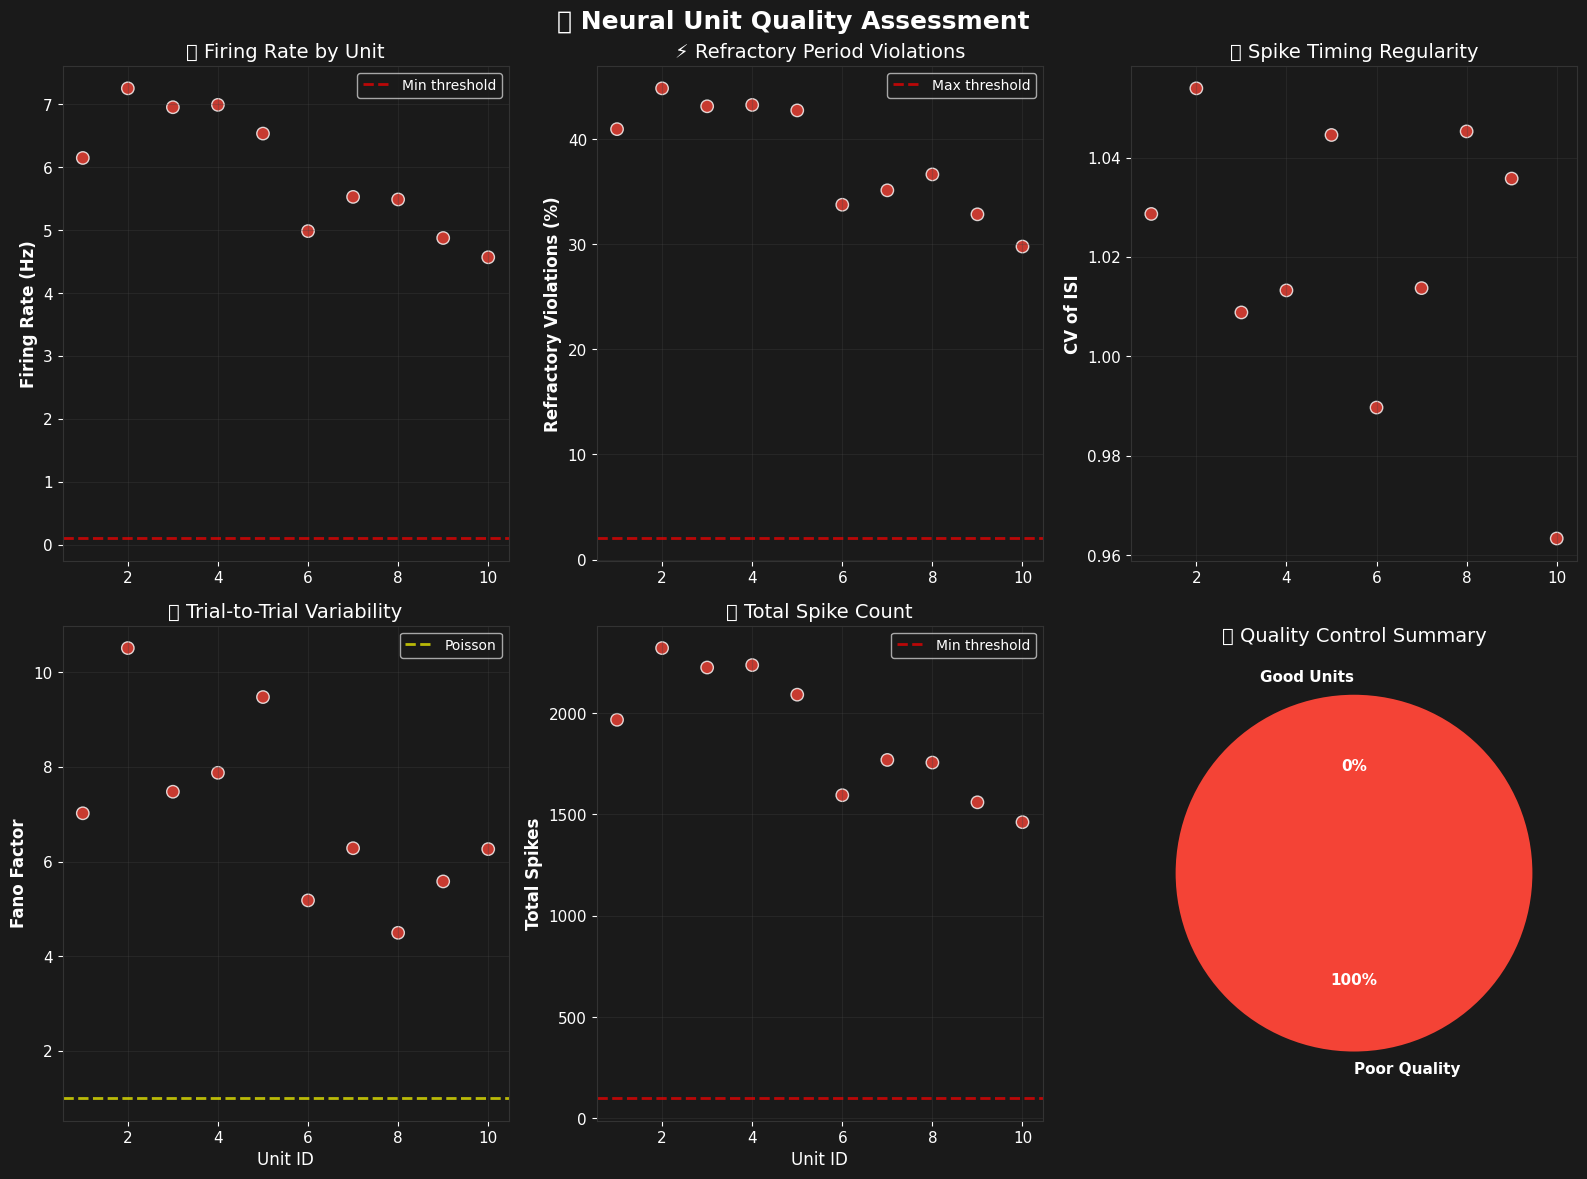

In [14]:
# Quality control analysis
print("🔍 Quality control analysis...")

unit_stats = analyzer.calculate_unit_stats(trials_data)
good_units = analyzer.filter_good_units(
    unit_stats,
    min_firing_rate=0.1,
    max_refractory_violations=0.02,
    min_total_spikes=50
)

print(f"✅ {len(good_units)}/{len(unit_stats)} units passed QC")
print(f"Good units: {good_units}")

# Visualize quality
fig = visualizer.plot_unit_quality(unit_stats, good_units)
plt.show()

📊 Visualizing Unit 1...


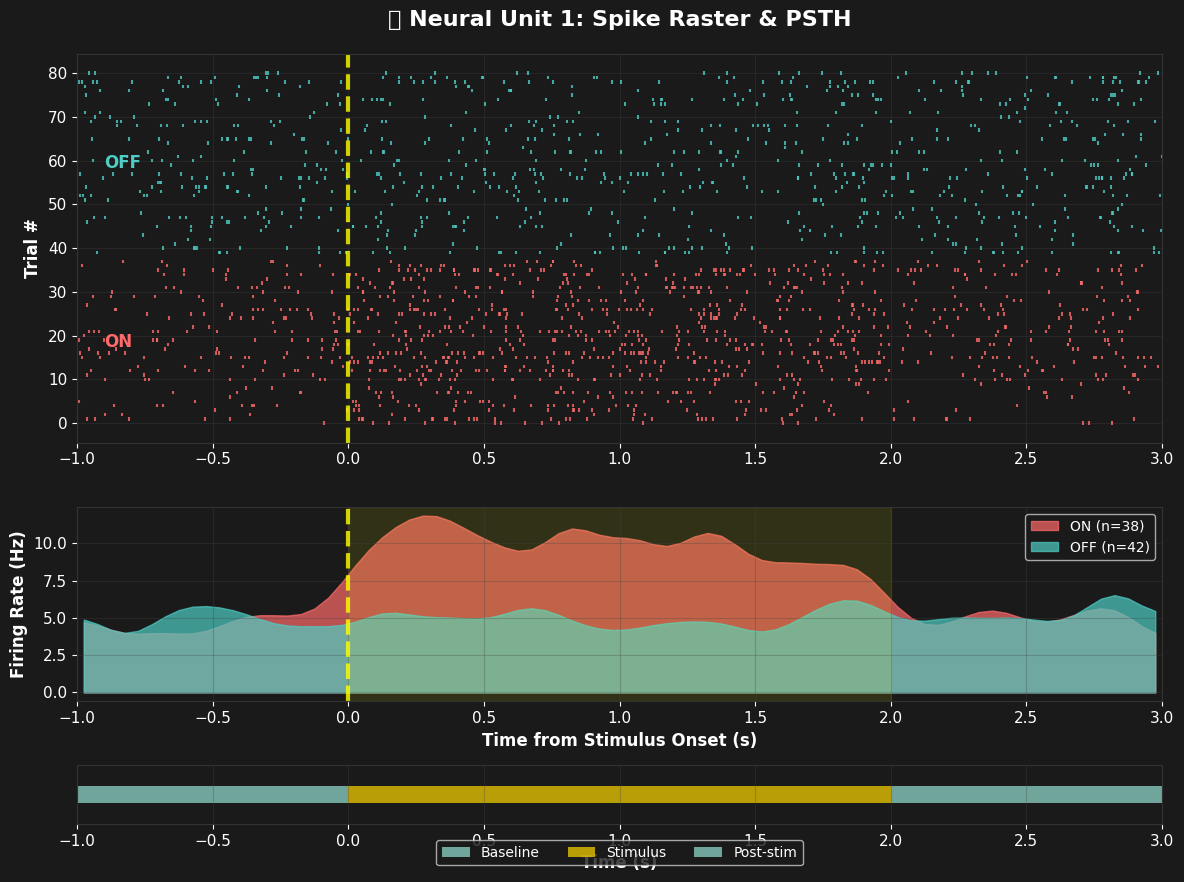

In [15]:
# Spike visualization
if good_units:
    example_unit = good_units[0]
else:
    example_unit = list(unit_stats.keys())[0]

print(f"📊 Visualizing Unit {example_unit}...")

# Beautiful raster plot and PSTH
fig = visualizer.plot_raster_psth(trials_data, example_unit)
plt.show()

In [16]:
# Find responsive units
print("📈 Testing for stimulus-responsive units...")

responsive_units = []
response_stats = {}

for unit_id in good_units:
    baseline_rates, stim_rates = analyzer.get_baseline_vs_stimulus_rates(
        trials_data, unit_id,
        baseline_window=(-1.0, 0.0),
        stim_window=(0.0, 2.0)
    )
    
    try:
        stat, p_value = stats.wilcoxon(baseline_rates, stim_rates, alternative='two-sided')
    except:
        p_value = 1.0
    
    response_stats[unit_id] = {
        'baseline_rate': np.mean(baseline_rates),
        'stimulus_rate': np.mean(stim_rates),
        'p_value': p_value,
        'responsive': p_value < 0.05
    }
    
    if p_value < 0.05:
        responsive_units.append(unit_id)
        print(f"   ✅ Unit {unit_id}: responsive (p = {p_value:.4f})")
    else:
        print(f"   ❌ Unit {unit_id}: not responsive (p = {p_value:.4f})")

print(f"\n📊 {len(responsive_units)}/{len(good_units)} units are responsive")

📈 Testing for stimulus-responsive units...

📊 0/0 units are responsive


In [17]:
# MAIN ANALYSIS: Rate vs Temporal Coding
analysis_units = responsive_units if responsive_units else good_units[:5]

if not analysis_units:
    analysis_units = list(unit_stats.keys())[:5]

print(f"🎯 Decoding with {len(analysis_units)} units: {analysis_units}")

# Extract features
rate_features = decoder.extract_rate_features(
    trials_data, analysis_units, time_window=(0.0, 2.0)
)

temporal_features = decoder.extract_temporal_features(
    trials_data, analysis_units, time_window=(0.0, 2.0), bin_size=0.1
)

labels = decoder.get_trial_labels(trials_data)

print(f"✅ Rate features: {rate_features.shape}")
print(f"✅ Temporal features: {temporal_features.shape}")

🎯 Decoding with 5 units: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5)]
✅ Rate features: (80, 5)
✅ Temporal features: (80, 100)


🎯 Running decoding analysis...

🎯 DECODING RESULTS:
   Rate accuracy:     0.900 ± 0.064
   Temporal accuracy: 0.900 ± 0.102
   Shuffle control:   0.375 ± 0.105


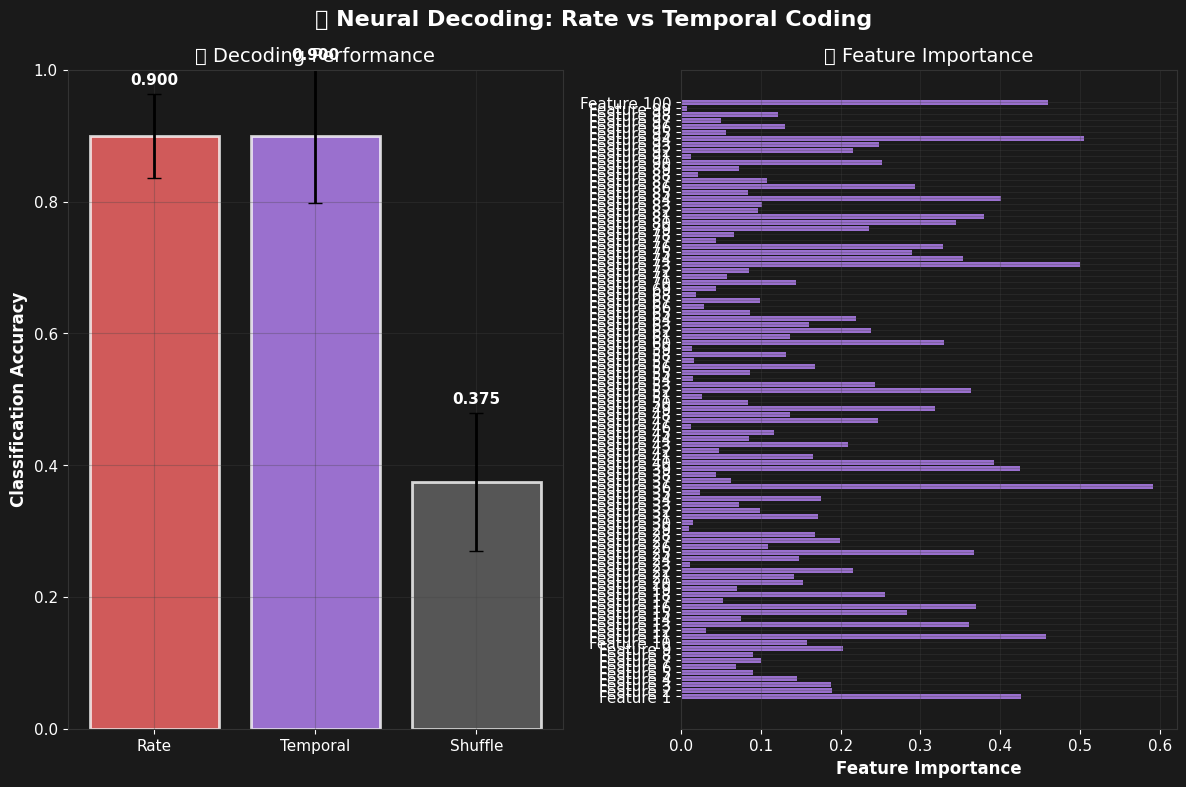

In [18]:
# Compare decoding performance
print("🎯 Running decoding analysis...")

results = decoder.compare_decoding_performance(
    rate_features=rate_features,
    temporal_features=temporal_features,
    labels=labels,
    n_folds=5
)

print("\n🎯 DECODING RESULTS:")
print(f"   Rate accuracy:     {results['rate_accuracy']:.3f} ± {results['rate_std']:.3f}")
print(f"   Temporal accuracy: {results['temporal_accuracy']:.3f} ± {results['temporal_std']:.3f}")
print(f"   Shuffle control:   {results['shuffle_accuracy']:.3f} ± {results['shuffle_std']:.3f}")

# Visualize results
fig = visualizer.plot_decoding_results(results)
plt.show()

In [19]:
# Final conclusions
rate_acc = results['rate_accuracy']
temp_acc = results['temporal_accuracy']
improvement = temp_acc - rate_acc

print("\n" + "="*60)
print("🎯 FINAL CONCLUSIONS")
print("="*60)

print(f"\n📊 Performance Summary:")
print(f"   • Rate-based decoding: {rate_acc:.1%}")
print(f"   • Temporal decoding: {temp_acc:.1%}")
print(f"   • Improvement: {improvement:+.1%}")

if improvement > 0.05:
    print(f"\n🎯 TEMPORAL CODING DETECTED!")
    print(f"   💡 Neurons encode information in precise spike timing")
elif improvement < -0.05:
    print(f"\n📊 RATE CODING DETECTED!")
    print(f"   💡 Neurons encode information in firing rates")
else:
    print(f"\n🤔 MIXED/UNCLEAR CODING")
    print(f"   💡 Both rate and timing may contribute")

print("\n🧠 Analysis Complete!")


🎯 FINAL CONCLUSIONS

📊 Performance Summary:
   • Rate-based decoding: 90.0%
   • Temporal decoding: 90.0%
   • Improvement: +0.0%

🤔 MIXED/UNCLEAR CODING
   💡 Both rate and timing may contribute

🧠 Analysis Complete!
